## The Diffusion Data Classification of images generated from MR scanner

In [1716]:
import Project_Fn_Utils
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Diffusion Data Classification
The goal is to classify labels of brain tissue pixel by pixel based on quantitative diffusion parameters.

### 1.1 Prepare training data
Entries in the CVS file 
1. sample
2. row
3. column
4. slice
5. T1 weighted anatomical Image
6. FA (Fractional Anisotropy)
7. MD (Mean Diffusivity)
8. AD (Azial Diffusivity)
9. RD (Radial Diffusivity)
10. Label (class)

#### 1.1.1 Load data
- Label 1: Thalamus
- Label 2: Corpus callosum (CC)
- Label 3: Cortical white matter (Cortical WM)

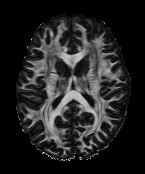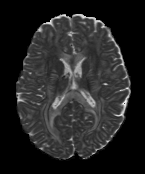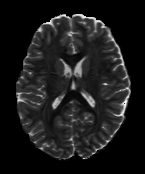 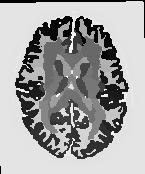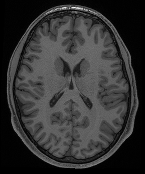 

In [1717]:
data = Project_Fn_Utils.load_data_1(num_rows_to_display = 1)
train_data = np.concatenate(data[:3],axis=0)
test_data = data[-1]


Data from /Users/bhavanik/Desktop/FAU Study/projects/data/dti/sampledata107725.csv:
[[1.077250e+05 7.300000e+01 1.230000e+02 6.300000e+01 7.041184e+02
  2.424968e-01 6.678018e-04 8.039927e-04 5.997064e-04 2.000000e+00]]


Data from /Users/bhavanik/Desktop/FAU Study/projects/data/dti/sampledata112314.csv:
[[1.123140e+05 7.300000e+01 8.500000e+01 6.300000e+01 7.827678e+02
  3.381405e-01 9.059209e-04 1.261528e-03 7.281175e-04 1.000000e+00]]


Data from /Users/bhavanik/Desktop/FAU Study/projects/data/dti/sampledata105620.csv:
[[1.056200e+05 7.300000e+01 1.000000e+02 7.100000e+01 8.332361e+02
  3.472693e-01 9.710606e-04 1.376888e-03 7.681468e-04 1.000000e+00]]


Data from /Users/bhavanik/Desktop/FAU Study/projects/data/dti/sampledata100206.csv:
[[1.002060e+05 7.300000e+01 9.000000e+01 6.500000e+01 8.977018e+02
  2.183588e-01 1.066592e-03 1.328058e-03 9.358592e-04 1.000000e+00]]




#### 1.1.2.	Features Selection
  


In [1718]:

# input_train, label_train, input_test, label_test
input_train= train_data[:,4:9].astype(float)
label_train= train_data[:,-1]- 1
input_test= test_data[:,4:9].astype(float)
label_test= test_data[:,-1] - 1
print(input_test.shape,input_train.shape)


nSamples = np.size(input_train, axis=0)
nSamples_test = np.size(input_test  ,axis=0)
nClasses = len(set(label_train))
nFeatures = np.size(input_train  ,axis=1)

print(f"Number of samples in training set: {nSamples}")
print(f"Number of samples in test set: {nSamples_test}")
print(f"Number of features: {nFeatures}")
print(f"Number of classes: {nClasses}")

(6145, 5) (17554, 5)
Number of samples in training set: 17554
Number of samples in test set: 6145
Number of features: 5
Number of classes: 3


####  1.1.3.	Training data
- Normalize
  - Use the same normalization factor for the same feature. 

In [1719]:

for n in range(nFeatures):
    norm_factor = np.max(input_train[:,n])
    input_train[:,n]= input_train[:,n]/norm_factor
    input_test[:,n]= input_test[:,n] / norm_factor

- Separate training (0.8) and validation (0.2) set.


In [1720]:
split_ratio = 0.8
setsize_train = np.ceil(nSamples*split_ratio).astype(int)
x_train = input_train[:setsize_train, :] 
y_train = label_train[:setsize_train]
x_val = input_train[setsize_train:, :]
y_val = label_train[setsize_train:]
print('Training set size is %d',x_train.shape,y_train.shape,x_val.shape,y_val.shape)

Training set size is %d (14044, 5) (14044,) (3510, 5) (3510,)


In [1721]:

batch_size= 512

x_train=torch.Tensor(x_train).float().to(DEVICE)
y_train = torch.Tensor(y_train).long().to(DEVICE)
x_val=torch.Tensor(x_val).float().to(DEVICE)
y_val = torch.Tensor(y_val).long().to(DEVICE)
x_test=torch.Tensor(input_test).float().to(DEVICE)
y_test = torch.Tensor(label_test).long().to(DEVICE)
print(x_test.shape,y_test.shape)
dataset_train = data_utils.TensorDataset(x_train,y_train)
dataloader_train = data_utils.DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
dataset_val = data_utils.TensorDataset(x_val,y_val)
dataloader_val = data_utils.DataLoader(dataset_val,batch_size=batch_size,shuffle=True)
dataset_test = data_utils.TensorDataset(x_test,y_test)
dataloader_test = data_utils.DataLoader(dataset_test,batch_size=batch_size,shuffle=False)

torch.Size([6145, 5]) torch.Size([6145])


#### 1.2. A fully connected Feed forward neural network 
-	The number of features for hidden layers:100
-	The number of FC layers: 3
-	Activation function: ReLU


In [1722]:
nElements = 80
nLayers = 3
dropout_rate = 0.5

Layers = []
Layers.append(nn.Linear(nFeatures, nElements, bias=True))
Layers.append(nn.ReLU())
Layers.append(nn.Dropout(dropout_rate))  # Add dropout after the input layer

for i in range(nLayers):
    Layers.append(nn.Linear(nElements, nElements, bias=True))
    Layers.append(nn.ReLU())
    Layers.append(nn.Dropout(dropout_rate))  # Add dropout after each hidden layer
    Layers.append(nn.BatchNorm1d(nElements))  # Add batch normalization after each hidden layer

Layers.append(nn.Linear(nElements, nClasses, bias=True))
model = nn.Sequential(*Layers)
model = model.to(DEVICE)
print(model)


Sequential(
  (0): Linear(in_features=5, out_features=80, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=80, out_features=80, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=80, out_features=80, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.5, inplace=False)
  (10): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Linear(in_features=80, out_features=80, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=80, out_features=3, bias=True)
)


#### 1.3.A loss function and an optimizer.
- Loss function: Cross entropy loss
- Optimizer: Adam optimizer
  - learning rate: Scheduler
  

In [1723]:

criterion= nn.CrossEntropyLoss()
#L2 regularization to prevent overfitting
optimizer = torch.optim.Adam(model.parameters())

#### 1.4. Define a trainer function.


In [1724]:
for x,l in dataloader_train:
    out = model(x)
    print(x.shape,l.shape,out.shape)
    break

torch.Size([512, 5]) torch.Size([512]) torch.Size([512, 3])


In [1725]:
def trainer(
    model,
    criterion,
    optimizer,
    dataloader_train,
    dataloader_val,
    num_epochs,
    lr_step_size=10,
    lr_gamma=0.5,
):
    loss_train = np.zeros(num_epochs)
    acc_train = np.zeros(num_epochs)
    loss_val = np.zeros(num_epochs)
    acc_val = np.zeros(num_epochs)
    
    # Define scheduler with step learning rate decay
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples
        loss_train[epoch] = epoch_loss
        acc_train[epoch] = epoch_acc

        # Validation
        model.eval()
        val_loss, val_acc = evaluate_model(model, criterion, dataloader_val)

        loss_val[epoch] = val_loss
        acc_val[epoch] = val_acc

        # Step the scheduler
        scheduler.step()

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return loss_train, acc_train, loss_val, acc_val

def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc


#### 1.5.	Train the network.
  - Epochs: 30


In [1726]:
torch.manual_seed(123)  # for reproducibility
epochs = 100
loss_train, acc_train, loss_val, acc_val = trainer(model,criterion,optimizer,dataloader_train,dataloader_val, num_epochs=epochs)

Epoch 1/100, Train Loss: 1.1297, Train Acc: 0.3932, Val Loss: 1.0476, Val Acc: 0.3311
Epoch 2/100, Train Loss: 0.9813, Train Acc: 0.5341, Val Loss: 1.0556, Val Acc: 0.3507
Epoch 3/100, Train Loss: 0.8498, Train Acc: 0.6398, Val Loss: 1.1176, Val Acc: 0.3550
Epoch 4/100, Train Loss: 0.7915, Train Acc: 0.6611, Val Loss: 1.0876, Val Acc: 0.3809
Epoch 5/100, Train Loss: 0.7780, Train Acc: 0.6698, Val Loss: 1.0546, Val Acc: 0.4111
Epoch 6/100, Train Loss: 0.7646, Train Acc: 0.6746, Val Loss: 1.0342, Val Acc: 0.4581
Epoch 7/100, Train Loss: 0.7595, Train Acc: 0.6833, Val Loss: 0.9992, Val Acc: 0.5017
Epoch 8/100, Train Loss: 0.7383, Train Acc: 0.6918, Val Loss: 0.9923, Val Acc: 0.5154
Epoch 9/100, Train Loss: 0.7227, Train Acc: 0.6956, Val Loss: 0.9075, Val Acc: 0.5741
Epoch 10/100, Train Loss: 0.7063, Train Acc: 0.7073, Val Loss: 0.8609, Val Acc: 0.6026
Epoch 11/100, Train Loss: 0.6943, Train Acc: 0.7145, Val Loss: 0.8193, Val Acc: 0.6311
Epoch 12/100, Train Loss: 0.6774, Train Acc: 0.7236,

## Model Evaluation

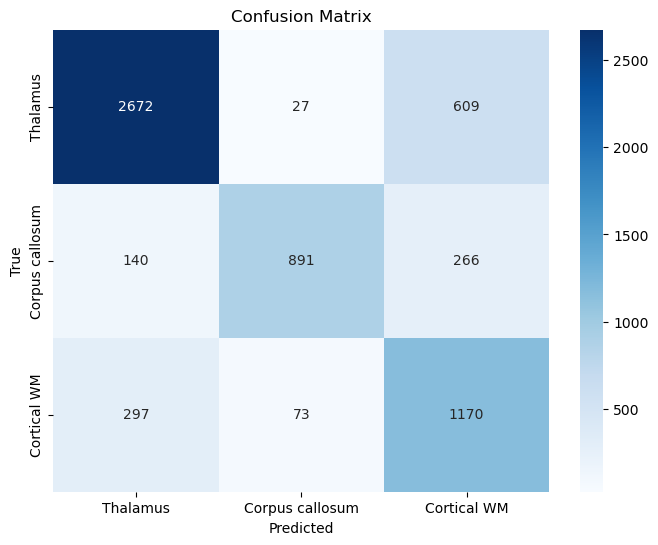

Test Accuracy: 0.770219690805533


In [1727]:
def calculate_confusion_matrix(model, dataloader, num_classes):
    model.eval()
    
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for local_batch, local_labels in dataloader:
            local_batch, local_labels = local_batch.to(DEVICE), local_labels.to(DEVICE)
            outputs = model(local_batch)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(local_labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy()) 
    Cf = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return Cf


Cf=calculate_confusion_matrix(model, dataloader_test , num_classes=3)
plt.figure(figsize=(8, 6))
sns.heatmap(Cf, annot=True, fmt='d', cmap='Blues', xticklabels=['Thalamus','Corpus callosum' ,'Cortical WM'], yticklabels=['Thalamus','Corpus callosum' ,'Cortical WM'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#Testing our model
model.eval()


correct = 0
total = 0

# Iterate over the test dataset
with torch.no_grad():
    for inputs, labels in dataloader_test:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = correct / total

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy}')

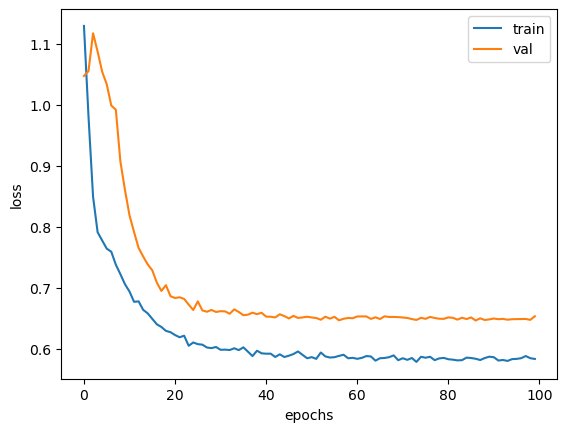

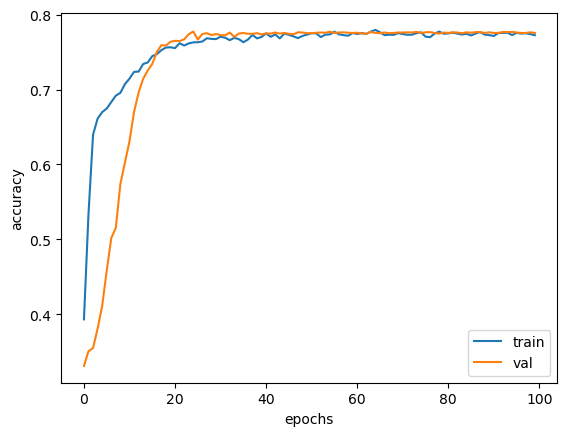

In [1728]:
Project_Fn_Utils.plot([loss_train,loss_val],['train','val'],xlabel="epochs",ylabel="loss")
Project_Fn_Utils.plot([acc_train,acc_val],['train','val'],smoothing=1,xlabel='epochs',ylabel="accuracy")